# Heart Disease Classification

The aim of this project is to predict the presence of heart disease in the patient using Decision Tree.

Variables included in the dataset :


|Variable     |Explanation|
|-------------|-----------|
|age           | Age in years|
|sex           | sex (1 = male; 0 = female)|
|cp            | chest pain type|
|trestbps      | resting blood pressure (in mm Hg on admission to the hospital)|
|chol          | serum cholestoral in mg/dl|
|fbs           | (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)|
|restecg       | resting electrocardiographic results|
|thalach       | maximum heart rate achieved|
|exang         | exercise induced angina (1 = yes; 0 = no)|
|oldpeak       | ST depression induced by exercise relative to rest|
|slope         | the slope of the peak exercise ST segment|
|ca            | number of major vessels (0-3) colored by flourosopy|
|thal          | 3 = normal; 6 = fixed defect; 7 = reversable defect|
|target        | diagnosis of heart disease (angiographic disease status)|

Dataset source: https://www.kaggle.com/ronitf/heart-disease-uc

## Project Preparation

Import libraries

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from sklearn.metrics import (accuracy_score, auc, 
                             classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, PrecisionRecallDisplay, 
                             roc_curve)
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV, 
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

Load the dataset

In [2]:
df = pd.read_csv("dataset/heart_disease.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data Summarization and Visualization

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Generate the descriptive statistic of the dataset

In [4]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Show the class distribution

In [5]:
class_dist = df.groupby("target").size()

for index, val in class_dist.items():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 138 samples (45.54%)
Class 1 : 165 samples (54.46%)


Calculate the Pearson's correlation of each variables

In [6]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


Text(0, 0.5, 'Count')

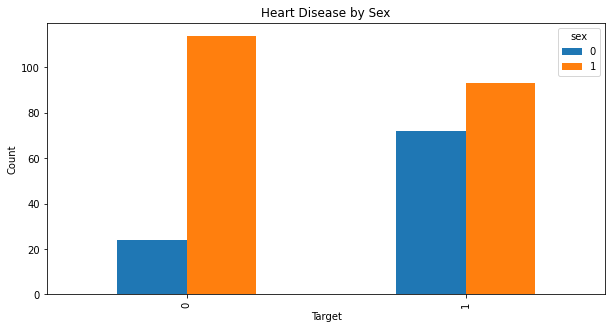

In [7]:
pd.crosstab(df.target, df.sex).plot(kind ="bar", figsize = (10,5))
plt.title("Heart Disease by Sex")
plt.xlabel("Target")
plt.ylabel("Count")

## Data Preparation

Split dataset into independent and dependent variables

In [8]:
X = df.drop(["target"], axis=1)
y = pd.DataFrame(df["target"]).copy()

Keep the feature names

In [9]:
feature_names = X.columns
feature_names

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

Split training and testing data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Scale the independent variable using StandardScaler

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Model Training

Build the classifier models

In [12]:
clf_method = DecisionTreeClassifier(random_state=42)

In [13]:
param_dist = {"max_depth": [3, None],
              "max_features": stats.randint(1, 9),
              "min_samples_leaf": stats.randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [14]:
clf_rscv = RandomizedSearchCV(clf_method, param_dist, n_iter=50, cv=5)
clf_rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015A600A5340>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015A600A5370>})

In [15]:
clf = clf_rscv.best_estimator_

Check the accuracy on the training set

In [16]:
y_train_predicted = clf.predict(X_train)
print(f'Accuracy on Training Set: {accuracy_score(y_train, y_train_predicted):.3f}')

Accuracy on Training Set: 0.893


Perform a 10-fold-cross-validation

In [17]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("10-fold-cross-validation accuracy: {:.3f}".format(scores.mean()))

10-fold-cross-validation accuracy: 0.773


## Model Evaluation

Predict the testing set

In [18]:
y_test_predicted = clf.predict(X_test)
print(f'Accuracy on Testing Set: {accuracy_score(y_test, y_test_predicted):.3f}')

Accuracy on Testing Set: 0.787


Display the classification report of the testing set

In [19]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.85      0.72      0.78        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61



Create confusion matrix for testing set

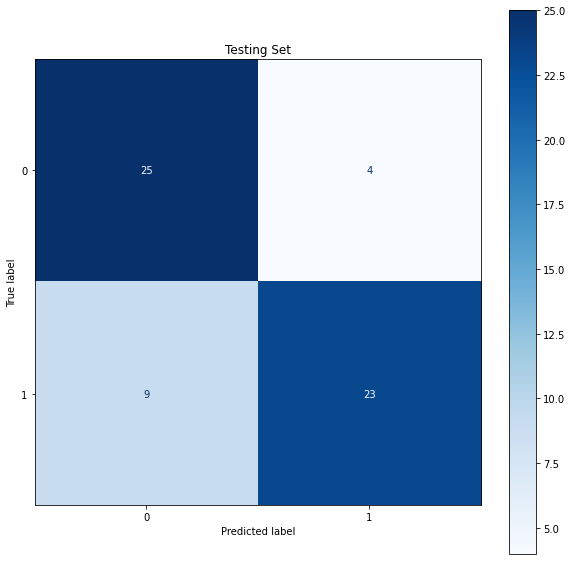

In [20]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_predicted))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Testing Set')
conf_mat_train.plot(cmap=plt.cm.Blues, ax=ax);

Plot the precision-recall curve

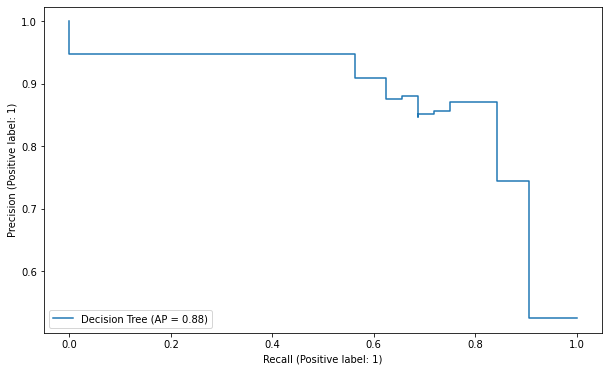

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="Decision Tree", ax=ax
)

Check models performance on testing set by accuracy and ROC AUC scores

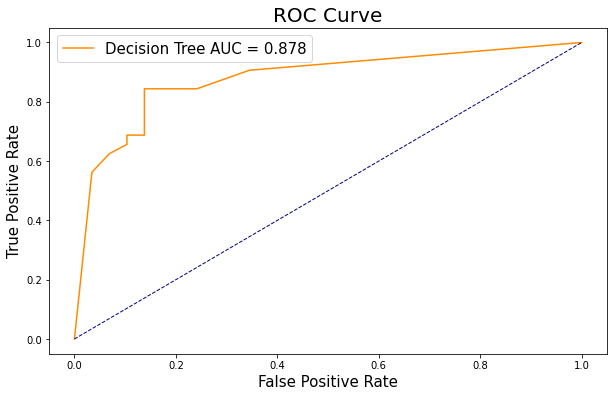

In [22]:
clf_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, clf_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Decision Tree AUC = {roc_auc:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.title("ROC Curve", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Visualize the decision tree

In [23]:
fig = plt.figure(figsize=(50,25), dpi=300)
plot_tree(clf, filled=True, rounded=True, feature_names=feature_names);

The decision tree visualization can be seen clearer [here](https://raw.githubusercontent.com/trizkynoviandy/heart-disease-prediction/main/figure/decistion_tree.png)

Save the figure to .png file

In [24]:
fig.savefig("figure/decistion_tree.png")

Save the model

In [25]:
filename = 'model/heart_disease_model.sav'
joblib.dump(clf, filename)

['model/heart_disease_model.sav']

## Conclusion

The decision tree model has been successfully developed, with an accuracy level of 0.836 on the training set. It was also validated using 10-fold-cross-validation and obtained an accuracy of 0.793. The model shows a fairly good accuracy value, and is able to provide predictions on the testing set with an accuracy of 0.836.